In [1]:
!pip --version

pip 22.0.4 from D:\miniconda\envs\base2\lib\site-packages\pip (python 3.7)



# 1.MLP

## 1.下载数据和环境

colab上使用，其中AAA是目录
```
def colab_download(proj_name):
    import requests

    project_name=proj_name

    url = f'http://kuroweb.tk:8000/api/v1/pack/wyftp/dataset/{project_name}.tar.gz'
    user, password = 'wuying', '123aaa'
    resp = requests.get(url, auth=(user, password))
    # write to file
    with open('download.tar.gz', 'wb') as f:
        f.write(resp.content)
    import tarfile

    # open file
    file = tarfile.open('download.tar.gz')
    # extracting file
    file.extractall('./')
    file.close()

    import shutil
    import os

    source_dir = f'./{project_name}'
    target_dir = './'

    file_names = os.listdir(source_dir)

    for file_name in file_names:
      try:
        shutil.move(os.path.join(source_dir, file_name), target_dir)
      except Exception as e:
        print(e,'at',file_name)
```

## 如果是kaggle，要另外加上
```
import sys
sys.path.append("/kaggle/working/")
```

In [2]:
def colab_download(proj_name,is_kaggle):
    import requests
    if is_kaggle:
        import sys
        sys.path.append("/kaggle/working/")

    project_name=proj_name

    url = f'http://kuroweb.tk:8000/api/v1/pack/wyftp/dataset/{project_name}.tar.gz'
    user, password = 'wuying', '123aaa'
    resp = requests.get(url, auth=(user, password))
    # write to file
    with open('download.tar.gz', 'wb') as f:
        f.write(resp.content)
    import tarfile

    # open file
    file = tarfile.open('download.tar.gz')
    # extracting file
    file.extractall('./')
    file.close()

    import shutil
    import os

    source_dir = f'./{project_name}'
    target_dir = './'

    file_names = os.listdir(source_dir)

    for file_name in file_names:
        try:
            shutil.move(os.path.join(source_dir, file_name), target_dir)
        except Exception as e:
            print(e,'at',file_name)



In [3]:
# !pip install -r requirements.txt
# colab_download('model',True)

In [4]:
import seaborn as sns

import os.path
from general_model.grow_numpy import GrowableNumpyArray
from general_model.list_batch_loader import ListBatchLoadDataset
from torch.utils.data import Dataset, DataLoader

from tool import ml
import os
from tool import wine_tool
import pandas as pd
from IPython.display import display
from collections import OrderedDict

import torch.nn as nn

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

import random
import torch.nn.functional as F
from general_model.layers import LambdaLayer
from tool.dbg import dbg
from tool import wine_data_loader
from model_helper.singlecudatrainer import SingleCudaTrainer
from model_helper.single_gpu_dataloader import SingleGpuTensorWrapper
from pytorch_classify.params import ClassifyParams
import tool.tflite_converter as tflite_converter
from pytorch_regression.regression_params import RegressionParams
import pytorch_regression
import importlib

D:\miniconda\envs\base2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class MlpClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # self.layers = torch.nn.Sequential(
        #     OrderedDict([
        #         # layernorm
        #         ('layernorm1', nn.LayerNorm([1000])),
        #         # ('layernorm1', nn.BatchNorm1d(1000)),
        #         ("h1", torch.nn.LazyLinear(1000)),
        #         ("act1", torch.nn.Sigmoid()),
        #         # ("h2", torch.nn.LazyLinear(1000)),
        #         # ("act2", torch.nn.Sigmoid()),
        #         ("h4", torch.nn.LazyLinear(15)),
        #         ("softmax", torch.nn.Softmax(dim=1))
        #     ]
        #     )
        # )
        self.norm = nn.LayerNorm([1000])
        self.layer1 = torch.nn.Sequential(
            OrderedDict([
                # layernorm
                # ('layernorm1', nn.LayerNorm([1000])),
                # ('batchnorm',nn.BatchNorm1d(1000)),
                # reshape to (batch_size, 1, 1000)
                ('reshape1', LambdaLayer(lambda x: x.view(x.shape[0], 1, -1))),
                # ('layernorm1', nn.BatchNorm1d(1000)),
                ("conv1", torch.nn.Conv1d(1, 16, kernel_size=3, stride=3, padding=0)),
                ("conv_activation1", torch.nn.ReLU()),
                ("conv2", torch.nn.Conv1d(16, 32, kernel_size=3, stride=3, padding=0)),
                ("conv_activation2", torch.nn.ReLU()),
                ("conv3", torch.nn.Conv1d(32, 64, kernel_size=3, stride=3, padding=0)),
                ("conv_activation3", torch.nn.ReLU()),
                ("flat1", LambdaLayer(lambda x: x.view(x.shape[0], -1))),
            ]
            )
        )

        self.layer2 = torch.nn.Sequential(
            OrderedDict([
                # ("h1", torch.nn.Linear(2368,1000)),
                ("h1", torch.nn.Linear(2368, 300)),
                ("act1", torch.nn.ReLU()),
                # ("h2", torch.nn.Linear(1000,512)),
                # ("act2", torch.nn.ReLU()),
                ("h4", torch.nn.Linear(300, 15)),
                ("softmax", torch.nn.Softmax(dim=1))
            ])
        )

    def forward(self, x):
        x = self.norm(x)
        # dbg(x)
        # input('view')
        x = self.layer1(x)
        # dbg(x.shape)
        x = self.layer2(x)
        # dbg(x.shape)
        return x

-----------------------
调参

由于Python中已经载入的模块不会重新载入，这就会导致一个问题，就是在外部修改的时候变更无法看到

网上的解决方案基本上都是使用importlib重载，但是这样有一个坏处，以后inport，都得用两句话来完成，这显然是不合理的。为了解决这个问题，我们把代码全部放到类里面，每次加载只下载模块，对不同的模块分段执行，当需要重新载入模块的时候，将整个Python kernel全部销毁，这样重启的速度依然很快

In [6]:
class ClassifyTrainer:
    def __init__(self):

        #%%

        self.param=ClassifyParams()
        self.param.epoch=0

        self.x, self.y = wine_data_loader.get_data3(use_onehot=False)
        # dbg(self.y)
        self.x, self.y, self.x1, self.y1 = wine_data_loader.split(self.x, self.y, 1-self.param.train_test_split)
        # use_gpu = False

        self.x = SingleGpuTensorWrapper(torch.from_numpy(self.x).float(), use_gpu=self.param.use_gpu)
        self.y = SingleGpuTensorWrapper(torch.from_numpy(self.y).long(), use_gpu=self.param.use_gpu)
        self.x1 = SingleGpuTensorWrapper(torch.from_numpy(self.x1).float(), use_gpu=self.param.use_gpu)
        self.y1 = SingleGpuTensorWrapper(torch.from_numpy(self.y1).long(), use_gpu=self.param.use_gpu)


        wine_dataset = ListBatchLoadDataset(self.x.tensor, self.y.tensor)
        self.dataloader = DataLoader(wine_dataset, batch_size=self.param.batch_size,
                                shuffle=True, num_workers=0)

    def train(self):
        m = MlpClassifier()

        self.trainer = SingleCudaTrainer(m, self.param.use_gpu)

        self.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=self.param.lr)  # optimize all cnn parameters

        self.loss_func = nn.CrossEntropyLoss()


        # dbg(self.x.tensor.device)
        # curve = torch.nn.LayerNorm([1000])(self.x.tensor)
        # dbg(torch.mean(curve[0]), torch.std_mean(curve[0]))

        # dbg('yshape',self.y.tensor.shape)

        # epoch = 1
        loss_list = []
        acc_list = []
        # epoch = 12000
        epoch = self.param.epoch
        for it in range(epoch):
            # dbg('before predict:')
            self.loss_batch = .0
            self.acc_percent = .0
            for _, dda in enumerate(self.dataloader):
                self.x, self.y = SingleGpuTensorWrapper(dda[0], use_gpu=self.param.use_gpu), SingleGpuTensorWrapper(dda[1], use_gpu=self.param.use_gpu)

                predict = trainer.model(self.x.tensor)
                # dbg('ok at it:', it)
                loss = self.loss_func(predict, self.y.tensor)  # calculate loss


                self.optimizer.zero_grad()  # clear gradients for this training step
                loss.backward()  # backpropagation, compute gradients
                self.optimizer.step()  # apply gradients

                self.loss_batch += loss.item()
                self.acc_percent += (torch.argmax(predict, dim=1) == self.y.tensor).float().mean()

            loss_list.append(self.loss_batch/len(self.dataloader))

            if it % 100 == 0:
                dbg('iteration:', it, 'loss:', self.loss_batch/len(self.dataloader),)
                dbg('acc:', (self.acc_percent/len(self.dataloader)).item())
                x1_predict=trainer.model(self.x1.tensor)
                val_percent = (torch.argmax(x1_predict, dim=1) == self.y1.tensor).float().mean()
                dbg('val acc:', val_percent)
                dbg(torch.argmax(x1_predict, dim=1)[:18])
                dbg(self.y1.tensor[:18])

                plt.plot(loss_list)
                plt.show()

        dbg('end')
        plt.show()

        # plt.pause(1)


        tflite_converter.torch_model_to_tflite(self.trainer.model)



# 这个文件到最后不要提交
数据上传

http://kuroweb.tk:8000/fs/wyftp/dataset/

ncdu分析存储空间

In [7]:

wine_json=ml.read_json("Wine.json")
wine_json

[{'name': '酒精',
  'id': '#102',
  'degree': 75.0,
  'items': [{'name': '#1', 'degree': 70.5},
   {'name': '#2', 'degree': 62.04},
   {'name': '#3', 'degree': 55.84},
   {'name': '#4', 'degree': 50.25},
   {'name': '#5', 'degree': 45.23},
   {'name': '#6', 'degree': 37.99},
   {'name': '#7', 'degree': 30.39},
   {'name': '#8', 'degree': 21.27},
   {'name': '#9', 'degree': 12.76},
   {'name': '#10', 'degree': 7.66},
   {'name': '#11', 'degree': 1.53}]},
 {'name': '国之娇子',
  'id': '#101',
  'degree': 53.0,
  'items': [{'name': '#1', 'degree': 50.88},
   {'name': '#2', 'degree': 47.83},
   {'name': '#3', 'degree': 44.96},
   {'name': '#4', 'degree': 41.36},
   {'name': '#5', 'degree': 37.22},
   {'name': '#6', 'degree': 33.5},
   {'name': '#7', 'degree': 26.8},
   {'name': '#8', 'degree': 19.3},
   {'name': '#9', 'degree': 11.58},
   {'name': '#10', 'degree': 6.95}]},
 {'name': '北京二锅头', 'id': '#1', 'degree': 42.0, 'items': []},
 {'name': '威海卫烧锅', 'id': '#2', 'degree': 40.0, 'items': []},
 {

# data4数据集加载

需要设置批处理大小

----------------
调参

In [45]:

class MlpRegression(nn.Module):

    def __init__(self,param):
        super().__init__()

        self.norm = nn.LayerNorm([1000])

        # 一维卷积神经网络
        # layers=[
        #     LambdaLayer(lambda x: x.view(x.shape[0], 1, -1)),
        # ]
        #
        # layers+=[
        #     nn.Conv1d(1, param.cnn_kernels[0], param.cnn_size, stride=param.cnn_stride),
        #     param.activation,
        #     nn.AvgPool1d(param.pool_size),
        #     # torch.nn.Dropout(0.5),
        # ]
        #
        # for idx,cnn in enumerate(param.cnn_kernels[1:]):
        #     layers+=[torch.nn.Conv1d(param.cnn_kernels[idx], cnn, kernel_size=param.cnn_size, stride=param.cnn_stride, padding=0),
        #     torch.nn.AvgPool1d(kernel_size=param.pool_size, stride=param.pool_size),
        #     param.activation,
        #     # torch.nn.Dropout(0.5),
        #  ]
        #
        # layers+=[LambdaLayer(lambda x: x.view(x.shape[0], -1)),]
        #
        # self.layer1 = torch.nn.Sequential(*layers)

        self.layer1=nn.Sequential(
            nn.Linear(1000,5000),
            param.activation,
            nn.Linear(5000,1),
        )

        # 最后的输出层,不要用lazy，会影响性能和精度训练速度
        self.layer2 = torch.nn.Sequential(
            OrderedDict([
                ("h1", torch.nn.Linear(104, 10)),
                ("act1", param.activation),
                # ("h2", torch.nn.Linear(1000,512)),
                # ("act2", torch.nn.ReLU()),
                ("h4", torch.nn.Linear(10, 1)),
            ])
        )

    def forward(self, x):
        x = self.norm(x)
        x = self.layer1(x)
        # dbg(x.shape)
        # x = self.layer2(x)
        # dbg(x.shape)
        return x

In [30]:
class RegressionTrainer:
    def __init__(self):
        self.param=RegressionParams()
        self.param.batch_size=64
        self.param.epoch=1
        self.param.lr=1e-9
        self.param.cnn_stride=1
        self.param.cnn_size=3
        self.param.pool_size=2
        self.param.lr_decay=0.99


    def load(self):

        self.x = GrowableNumpyArray(dtype=np.float,grow_speed=16)
        self.y = GrowableNumpyArray(dtype=np.float,grow_speed=16)

        for wine in wine_json:
            base_wine_path='data4/'+wine['id']
            dbg(wine['name'])
            if not os.path.exists(base_wine_path):
                dbg('not exists:', base_wine_path)
                continue
            # load data
            dirs = ml.getAllFiles(f'{base_wine_path}')
            for d in dirs:
                path=d
                files = ml.getAllFileRecursively(path)
                for f in files:
                    self.x.update(wine_tool.col2data_to_float_list(f))
                    self.y.add(wine['degree'])
                    # self.x = np.append(self.x, wine_tool.col2data_to_float_list(f))
                    # self.y = np.append(self.y, wine['degree'])

            # load item_data
            for wine_item in wine['items']:
                sub_wine_path=base_wine_path+'_'+wine_item['name']

                dirs = ml.getAllFiles(f'{sub_wine_path}')
                dbg(wine_item)
                for d in dirs:
                    path=d
                    files = ml.getAllFileRecursively(path)
                    for f in files[:100]:
                        self.x.update(wine_tool.col2data_to_float_list(f))
                        self.y.add(wine_item['degree'])
                        # self.x = np.append(self.x, wine_tool.col2data_to_float_list(f))
                        # self.y = np.append(self.y, wine_item['degree'])




        self.x = self.x.finalize()
        self.x = self.x.reshape((-1, 1000))


        self.y=self.y.finalize()


        plt.plot(sorted(self.y))
        plt.plot(self.y)


        # normalize

        self.y=self.y/100


        layer_normed_x=torch.nn.LayerNorm([1000])(torch.tensor(self.x,dtype=torch.float))
        i=0
        while i<3:
            indice=i
            plt.plot(layer_normed_x[indice].detach().numpy(),label=self.y[indice])
            plt.legend()
            plt.show()
            i+=1

        self.numpy_x,self.numpy_y,self.numpy_x1,self.numpy_y1=wine_data_loader.split(self.x,self.y,1-self.param.train_test_split)


    def create_dataloader_from_loaded_numpy(self):
        self.x=SingleGpuTensorWrapper(torch.from_numpy(self.numpy_x).float(),self.param.use_gpu)
        self.y=SingleGpuTensorWrapper(torch.from_numpy(self.numpy_y).float(),self.param.use_gpu)
        self.x1=SingleGpuTensorWrapper(torch.from_numpy(self.numpy_x1).float(),self.param.use_gpu)
        self.y1=SingleGpuTensorWrapper(torch.from_numpy(self.numpy_y1).float(),self.param.use_gpu)

        wine_dataset = ListBatchLoadDataset(self.x.tensor, self.y.tensor)
        self.dataloader = DataLoader(wine_dataset, batch_size=self.param.batch_size,
                                shuffle=True, num_workers=0)

    def load_model_and_train(self):

        dbg(self.x.tensor.shape)
        dbg(MlpRegression(self.param))


        trainer=SingleCudaTrainer(MlpRegression(self.param),use_gpu=self.param.use_gpu)

        optimizer = torch.optim.Adam(trainer.model.parameters(), lr=self.param.lr)  # optimize all cnn parameters

        loss_func = nn.MSELoss()
        # loss_func = nn.L1Loss()

        # epoch = 1
        loss_list = []
        acc_list = []
        # epoch = 12000
        epoch = self.param.epoch
        for it in range(epoch):
            # dbg('before predict:')
            loss_batch = .0

            for idx, dda in enumerate(self.dataloader):
                x, y = SingleGpuTensorWrapper(dda[0], use_gpu=self.param.use_gpu), SingleGpuTensorWrapper(dda[1], use_gpu=self.param.use_gpu)

                predict = trainer.model(x.tensor)
                # dbg('ok at it:', it)
                loss = loss_func(predict, y.tensor)  # calculate loss


                optimizer.zero_grad()  # clear gradients for this training step
                loss.backward()  # backpropagation, compute gradients
                optimizer.step()  # apply gradients

                loss_batch += loss.item()
                # dbg('go',idx)

            loss_list.append(loss_batch/len(self.dataloader))

            if it % 50 == 0:
                # https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
                # for g in optimizer.param_groups:
                #     g['lr'] = ml.read_json('pytorch_regression/real_time_config.json')['lr']
                    # g['lr'] = self.param.lr_decay*g['lr']

                dbg('lr -> to:', optimizer.param_groups[0]['lr'])
                dbg('iteration:', it, 'loss:', loss_batch/len(self.dataloader),)

                # predict
                # predict = trainer.model(x1.tensor)

                # 用最后一个batch测试

                # loss
                plt.plot(loss_list[10:] if len(loss_list) > 10 else loss_list, label='loss')
                plt.legend(loc='upper right')
                plt.show()
                # plt.plot((predict.reshape(-1,)-y.tensor).detach().cpu().numpy(),'r.')
                # plt.show()
                # plt.plot(predict.detach().cpu().numpy(), 'r.')
                # plt.plot(y1.tensor.detach().cpu().numpy(),'b.')

                dict = {'predict' : predict[-5:,0].detach().cpu().numpy(),
                        'truth' : y.tensor[-5:].detach().cpu().numpy(),
                        'sub': (predict[-5:,0].detach().cpu().numpy()-y.tensor[-5:].detach().cpu().numpy()),
                        }
                df = pd.DataFrame(dict)

                # displaying the DataFrame
                display(df.T)

                for g in optimizer.param_groups:
                    g['lr'] = self.param.lr_decay*g['lr']

                dbg('lr reduce to:', optimizer.param_groups[0]['lr'])
                dbg('iteration:', it, 'loss:', loss_batch/len(self.dataloader),)

        dbg('end')
        plt.show()

# best loss:
        0.03024327833290127

        0.030054485214570763


D:\miniconda\envs\base2\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
D:\miniconda\envs\base2\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


酒精
{'name': '#1', 'degree': 70.5}
{'name': '#2', 'degree': 62.04}
{'name': '#3', 'degree': 55.84}
{'name': '#4', 'degree': 50.25}
{'name': '#5', 'degree': 45.23}
{'name': '#6', 'degree': 37.99}
{'name': '#7', 'degree': 30.39}
{'name': '#8', 'degree': 21.27}
{'name': '#9', 'degree': 12.76}
{'name': '#10', 'degree': 7.66}
{'name': '#11', 'degree': 1.53}
国之娇子
{'name': '#1', 'degree': 50.88}
{'name': '#2', 'degree': 47.83}
{'name': '#3', 'degree': 44.96}
{'name': '#4', 'degree': 41.36}
{'name': '#5', 'degree': 37.22}
{'name': '#6', 'degree': 33.5}
{'name': '#7', 'degree': 26.8}
{'name': '#8', 'degree': 19.3}
{'name': '#9', 'degree': 11.58}
{'name': '#10', 'degree': 6.95}
北京二锅头
威海卫烧锅
丁香情
原浆
北大仓
苦芥
五粮情
not exists: data4/#13
景芝白干
衡水老白干
老酒壶
牛栏山陈酿
杜二酒
小郎酒
闷倒驴
not exists: data4/#14
牛栏山二锅头
not exists: data4/#15


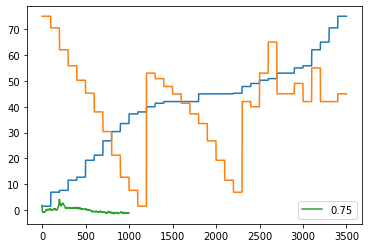

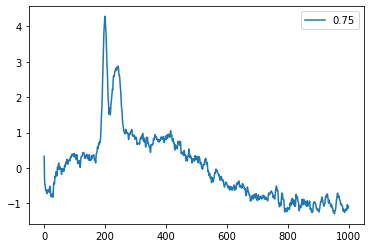

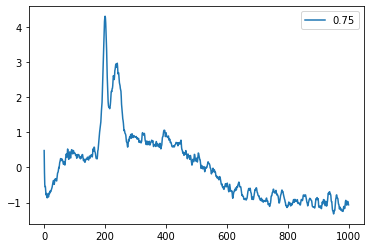

In [31]:

trainer=RegressionTrainer()
trainer.load()

In [32]:
trainer.param.batch_size=1000
trainer.create_dataloader_from_loaded_numpy()

D:\miniconda\envs\base2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

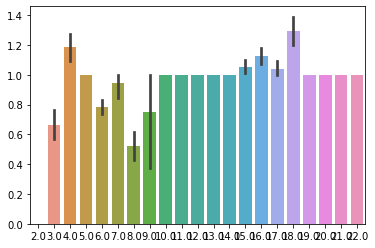

In [19]:
# sns.barplot(np.max(trainer.x.tensor.detach().cpu().numpy(),axis=1)//5000,trainer.y.tensor.detach().cpu().numpy()//0.3)

torch.Size([2100, 1000])
MlpRegression(
  (norm): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (layer1): Sequential(
    (0): Linear(in_features=1000, out_features=5000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5000, out_features=1, bias=True)
  )
  (layer2): Sequential(
    (h1): Linear(in_features=104, out_features=10, bias=True)
    (act1): Tanh()
    (h4): Linear(in_features=10, out_features=1, bias=True)
  )
)


D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


lr -> to: 1e-06
iteration: 0 loss: 0.7286077340443929


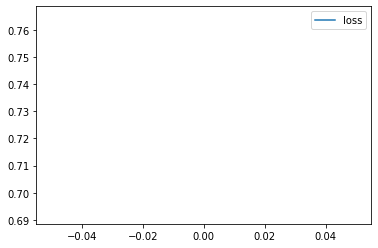

,0,1,2,3,4
predict,-0.421064,-0.44921,-0.477605,-0.443183,-0.437027
truth,0.372200,0.65000,0.490000,0.650000,0.650000
sub,-0.793265,-1.09921,-0.967605,-1.093183,-1.087027


lr reduce to: 9.9e-07
iteration: 0 loss: 0.7286077340443929


D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


lr -> to: 9.9e-07
iteration: 50 loss: 0.033148925130565964


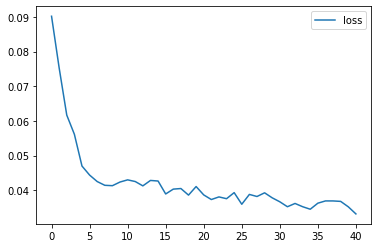

,0,1,2,3,4
predict,0.450168,0.287039,0.463556,0.388082,0.410553
truth,0.303900,0.400000,0.372200,0.303900,0.115800
sub,0.146268,-0.112961,0.091356,0.084182,0.294753


lr reduce to: 9.801e-07
iteration: 50 loss: 0.033148925130565964


D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


lr -> to: 9.801e-07
iteration: 100 loss: 0.03530144815643629


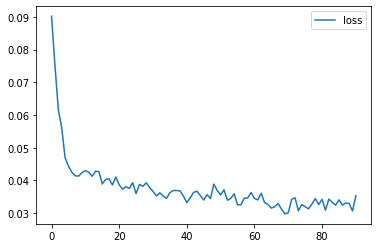

,0,1,2,3,4
predict,0.43668,0.374306,0.347514,0.422479,0.391239
truth,0.19300,0.490000,0.750000,0.413600,0.620400
sub,0.24368,-0.115694,-0.402486,0.008879,-0.229161


lr reduce to: 9.70299e-07
iteration: 100 loss: 0.03530144815643629


D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


lr -> to: 9.70299e-07
iteration: 150 loss: 0.03057333268225193


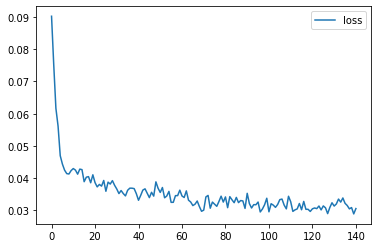

,0,1,2,3,4
predict,0.406056,0.404135,0.410107,0.377918,0.460915
truth,0.193000,0.193000,0.450000,0.502500,0.420000
sub,0.213056,0.211135,-0.039893,-0.124582,0.040915


lr reduce to: 9.6059601e-07
iteration: 150 loss: 0.03057333268225193


D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


lr -> to: 9.6059601e-07
iteration: 200 loss: 0.031148778274655342


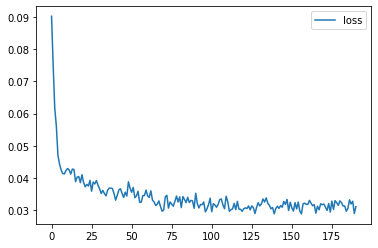

,0,1,2,3,4
predict,0.400011,0.406331,0.415743,0.40004,0.416338
truth,0.530000,0.372200,0.268000,0.42000,0.420000
sub,-0.129989,0.034131,0.147743,-0.01996,-0.003662


lr reduce to: 9.509900499000001e-07
iteration: 200 loss: 0.031148778274655342


D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


lr -> to: 9.509900499000001e-07
iteration: 250 loss: 0.029590532804528873


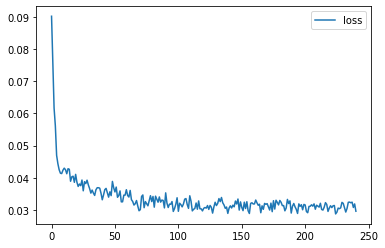

,0,1,2,3,4
predict,0.409146,0.402574,0.408834,0.406607,0.413779
truth,0.530000,0.450000,0.450000,0.335000,0.650000
sub,-0.120854,-0.047426,-0.041166,0.071607,-0.236221


lr reduce to: 9.414801494010001e-07
iteration: 250 loss: 0.029590532804528873


D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\miniconda\envs\base2\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end


In [46]:
trainer.param.cnn_kernels=[2,2,4,4,8,8]
trainer.param.activation=nn.Tanh()
trainer.param.epoch=300
trainer.param.lr=0.000001
trainer.param.lr_decay=0.99

trainer.load_model_and_train()

# best loss
0.03011364997787909